In [1]:
%matplotlib inline
import datetime

import numpy as np
import pandas as pd
import requests

from matplotlib import pyplot as plt
plt.style.use('blog') # Comment this line to run yourself

In [2]:
ENDPOINT = 'http://elections.huffingtonpost.com/pollster/api/polls.json'

In [3]:
def gen_poll_pages():
    page = 1
    params = {
        'topic': '2016-president',
        'state': 'us',
        'after': '2016-01-01',
        'showall': 'false'
    }
    while True:
        params['page'] = page
        results = requests.get(ENDPOINT, params=params).json()
        yield results
        if len(results) < 10:
            break
        page += 1 

In [4]:
def gen_polls(subpopulation='Likely Voters'):
    yield from (
        (poll['end_date'], sub)
        for page in gen_poll_pages()
        for poll in page
        for question in poll['questions']
        for sub in question['subpopulations'] 
        if question['code'].startswith('16-US-Pres-GE')
        and sub['name'] == subpopulation

    )

In [5]:
def gen_poll_rows(subpopulation='Likely Voters',
                  candidates={'Hillary Clinton', 'Donald Trump'}
                 ):
    candidates = set(candidates)
    for poll_id, (date, poll) in enumerate(gen_polls(subpopulation)):
        yield poll_id, 'date', date
        observations = poll['observations']
        if observations is None:
            continue
        other = 0
        for response in poll['responses']:
            try: 
                candidate = ' '.join([response['first_name'], response['last_name']])
            except TypeError:
                if 'Gary' in response['choice'] and 'Johnson' in response['choice']:
                    candidate = 'Gary Johnson'
                elif 'Jill' in response['choice'] and 'Stein' in response['choice']:
                    candidate = 'Jill Stein'
                else:
                    other += response['value']
                    continue
            if candidate not in candidates:
                other += response['value']
                continue
            yield poll_id, candidate, response['value'] / 100 * observations
        yield poll_id, "Other", other / 100 * observations

In [6]:
def get_polling_record(subpopulation='Likely Voters',
                       candidates=('Hillary Clinton', 'Donald Trump')):
    raw = pd.DataFrame(
        gen_poll_rows(subpopulation=subpopulation, candidates=candidates),
        columns=['poll_id', 'var', 'value']
    )
    record = (
        raw.set_index(['poll_id', 'var'])['value']
        .unstack()
        .dropna(subset=candidates)
        .fillna(0)
    )
    record['date'] = pd.to_datetime(record['date'])
    return record.set_index('date', append=True)
            

In [35]:
def run_simulation(daily, trials=10000):
    state = daily.set_index(['date', 'candidate']).xs(daily['date'].max())
    trials = pd.DataFrame({i: np.random.randn(trials) * j['std'] + j['mean']
                           for i, j in state.iterrows()})
    winner = trials.idxmax(axis=1)
    return pd.Series({i: (winner == i).mean() for i in state.index})
    

In [8]:

def get_daily_state(subpopulation='Likely Voters', candidates=('Donald Trump', 'Hillary Clinton')):
    record = get_polling_record(subpopulation=subpopulation, candidates = candidates)
    votes = pd.Series({i: 0 for i in record.columns})
    rows = []
    for day in pd.DatetimeIndex(start='2016-01-01', end=datetime.datetime.today(), freq='d'):
        votes *= .5
        try:
            votes += record.xs(day, level='date').sum()
        except KeyError:
            pass
        means = votes / votes.sum()
        stds = np.sqrt((means * (1 - means)) / votes.sum())
        for candidate, mean, std in zip(record.columns, means, stds):
            rows.append((day, candidate, mean, std))
    return pd.DataFrame(rows, columns=['date', 'candidate', 'mean', 'std']).dropna()


In [9]:
daily = get_daily_state(candidates=['Hillary Clinton', 'Donald Trump'])

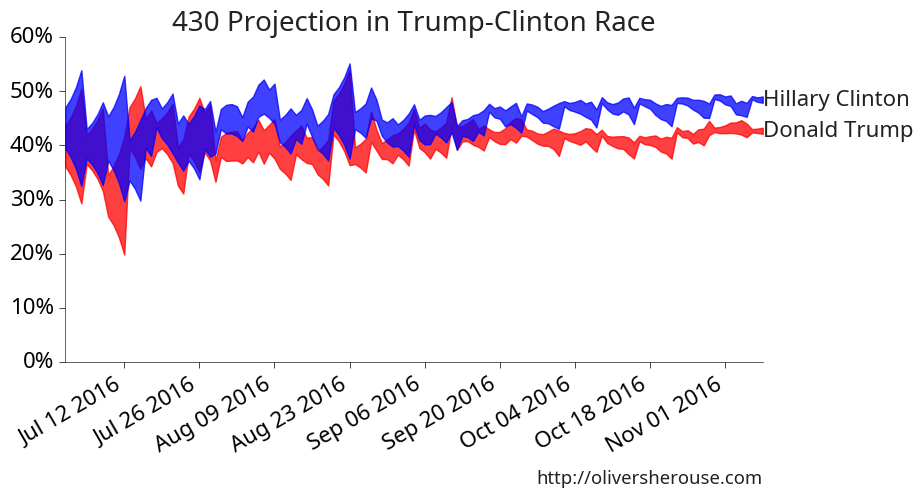

In [24]:
colors = {'Donald Trump': 'red', 'Hillary Clinton': 'blue', 'Gary Johnson': 'grey', 'Jill Stein': 'green'}
start='2016-07-01'
candidates = [i for i in daily['candidate'].unique() if i != 'Other']
to_plot = daily[daily['date'] >= pd.to_datetime(start)].set_index(['candidate', 'date'])
fig, ax = plt.subplots()
for candidate in candidates:
    mean = to_plot.xs(candidate)['mean']
    ci = 2.5 * to_plot.xs(candidate)['std']
    ax.fill_between(mean.index, mean - ci, mean + ci, color=colors.get(candidate), alpha=.75)
    #ax.plot(mean.index, mean, color=colors.get(candidate), lw=3)
    ax.text(ax.get_xbound()[-1], mean[-1], candidate, va='center',)


ax.set_ybound(0)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_yticklabels("{:.0%}".format(i) for i in ax.get_yticks())
ax.set_title("430 Projection in Trump-Clinton Race")
fig.autofmt_xdate()
pos = ax.get_position()
fig.set_size_inches(10, 5)
ax.set_position([pos.x0, pos.y0 + .05, .9 * pos.width, pos.height-.05])
fig.text(pos.x0 + .9 * pos.width, 0, 'http://oliversherouse.com', size='small', va='bottom', ha='right')

fig.savefig('Clinton-Trump', bbox='tight')


In [11]:
daily.set_index(['date', 'candidate']).xs(daily['date'].max()).applymap('{:0.1%}'.format)

,mean,std
candidate,,
Donald Trump,42.7%,0.2%
Hillary Clinton,48.4%,0.2%
Other,8.9%,0.1%


In [36]:
run_simulation(daily)

Donald Trump       0.0
Hillary Clinton    1.0
Other              0.0
dtype: float64